<a href="https://colab.research.google.com/github/mohmiim/MLIntroduction/blob/master/session-7/generate_numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
from numpy import expand_dims
from keras.datasets.mnist import load_data

def loadSamples():
  (trainX, _), (_, _) = load_data()
  # conv layer needs 3d array, so we will expand the dimensions
  X = expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  # scale to [0,1]
  X = X / 255.0
  print(X.shape)
  return X

Using TensorFlow backend.


In [0]:
from numpy.random import randn

LATENT_DIM = 100

def generate_latent_input(latentDim, count):
  X = randn(latentDim * count)
  X = X.reshape((count,latentDim))
  X = X.astype('float32')
  return X

In [0]:
from numpy import zeros
def create_generated_samples(generator, latentDim, count):
  X = generate_latent_input(latentDim, count)
  gen_images = generator.predict(X)
  # labels here will be fake ==> 0
  y = zeros((count,1))
  return gen_images, y

In [0]:
from numpy.random import randint
from numpy import ones

def generate_real_samples(dataset, n_samples):
  index = randint(0, dataset.shape[0], n_samples)
  X = dataset[index]
  # mark them as real
  y = ones((n_samples, 1))
  return X, y

In [0]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.initializers import RandomNormal 

DISC_FILTER_SIZE = 3
DISC_LEAKY_ALPHA = 0.2 

init = RandomNormal(stddev=0.02)

def createDiscConvLayer(model):
  model.add(Conv2D(64,
                   (DISC_FILTER_SIZE,DISC_FILTER_SIZE),
                   strides=(2, 2),
                   padding='same',
                   input_shape=INPUT_SIZE,
                   kernel_initializer=init))
  model.add(LeakyReLU(alpha=DISC_LEAKY_ALPHA))
  return model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

INPUT_SIZE = (28,28,1)
DISC_DROPOUT = 0.4
def create_discriminator(input_shape=INPUT_SIZE):
    print("Creating Discriminator")
    model = Sequential()
    # down sample to 14 X 14
    createDiscConvLayer(model)
    # down sample to 7 X 7
    createDiscConvLayer(model)

    model.add(Flatten())
    model.add(Dropout(DISC_DROPOUT))
    activation = 'sigmoid'
    loss= 'binary_crossentropy'
    model.add(Dense(1, activation=activation))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    print("Created Discriminator")
    model.summary()
    return model

In [0]:
from tensorflow.keras.layers import Conv2DTranspose

GEN_FILTER_SIZE = 4
GEN_LEAKY_ALPHA = 0.2

def addGenConvTransPoseLayer(model):
  model.add(Conv2DTranspose(128, (GEN_FILTER_SIZE,GEN_FILTER_SIZE),
                            strides=(2,2),
                            padding='same',
                            kernel_initializer=init))
  model.add(LeakyReLU(alpha=GEN_LEAKY_ALPHA))

In [0]:
from tensorflow.keras.layers import Reshape

def create_generator(latent_dim = LATENT_DIM):
    print("Creating Genertor")
    model = Sequential()
    # foundation for 7*7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=GEN_LEAKY_ALPHA))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14 * 14
    addGenConvTransPoseLayer(model)
    # upsample to 28*28
    addGenConvTransPoseLayer(model)
    # output layer
    model.add(Conv2D(1, (7,7),
                     activation='sigmoid',
                     padding='same',
                     kernel_initializer=init))
    print("Created Generator")
    model.summary()
    return model


In [0]:
def create_gan(generator, discriminator):
  print("Creating GAN")
  # freeze the weights of the discriminator
  discriminator.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(generator)
  # add the discriminator
  model.add(discriminator)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  loss= 'binary_crossentropy'
  model.compile(loss=loss, optimizer=opt)
  print("Created GAN")
  model.summary()
  return model

In [0]:
from matplotlib import pyplot

def saveSamples(samples, epoch, n=5):
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(samples[i, :, :, 0], cmap='gray_r')
  # save to file
  #filename = 'generated_plot_e%04d.png' % (epoch+1)
  #pyplot.savefig(filename)
  #pyplot.close()
  pyplot.show()

def generateSampleOutput(epoch, generator, n_samples=10):
  X = generate_latent_input(LATENT_DIM, n_samples*n_samples)
  y = generator.predict(X)
  # save plot
  saveSamples(y, epoch, n_samples)
  # save the generator model tile file
  #filename = 'generator_model_%04d.h5' % (epoch + 1)
  #generator.save(filename)

In [0]:
import math

def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=50, n_batch=256):
  batches_count = math.ceil(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    print(" ")
    # enumerate batches over the training set
    print('>Epoch:%d' % (i+1), end = " ")
    for j in range(batches_count):
      # generate real samples
      X_real, y_real = generate_real_samples(dataset, n_batch)
      # generate 'fake' examples
      X_fake, y_fake = create_generated_samples(generator, latent_dim, half_batch)
      # update discriminator  weights
      lossReal, _ = discriminator.train_on_batch(X_real, y_real)
      lossFake, _ = discriminator.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_input(latent_dim, n_batch)
      # mark fake as real
      y_gan = ones((n_batch, 1))
      # update the generator weights
      loss_generator = gan.train_on_batch(X_gan, y_gan)
      print(".", end="")
    if i%10 == 0 :
      generateSampleOutput(i+1,generator,4)

In [0]:
dataset  = loadSamples()

# create the discriminator
discriminator = create_discriminator()
# create the generator
generator = create_generator(LATENT_DIM)
# create the gan
gan = create_gan(generator, discriminator)






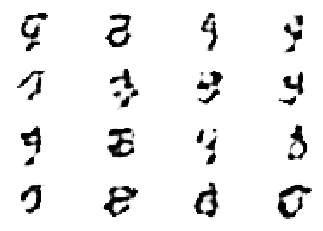

 
>Epoch:1 ...........................................................................................................................................................................................................................................

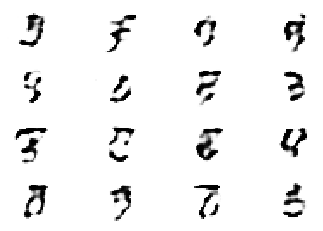

 
>Epoch:2 ........................................................................................................................................................................................................................................... 
>Epoch:3 ........................................................................................................................................................................................................................................... 
>Epoch:4 ........................................................................................................................................................................................................................................... 
>Epoch:5 ........................................................................................................................................................................................................................................... 
>Epoch:6 .....

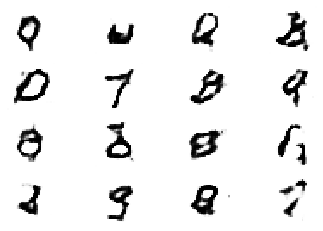

 
>Epoch:12 ........................................................................................................................................................................................................................................... 
>Epoch:13 ........................................................................................................................................................................................................................................... 
>Epoch:14 ........................................................................................................................................................................................................................................... 
>Epoch:15 ........................................................................................................................................................................................................................................... 
>Epoch:16 

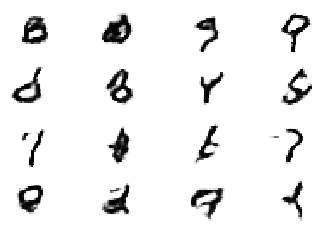

 
>Epoch:22 ........................................................................................................................................................................................................................................... 
>Epoch:23 ........................................................................................................................................................................................................................................... 
>Epoch:24 ........................................................................................................................................................................................................................................... 
>Epoch:25 ......................................................................

In [0]:
generateSampleOutput(0,generator,4)
# train model
train(generator, discriminator, gan, dataset, LATENT_DIM)